In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Subset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import random
from sklearn.model_selection import KFold
import os
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def load_data_new():
    X_data_train = pd.read_csv('/content/drive/MyDrive/CaReTS/prs_HWM_train.csv')
    Y_data_train = X_data_train

    X_data_test = pd.read_csv('/content/drive/MyDrive/CaReTS/prs_HWM_test.csv')
    Y_data_test = X_data_test

    X_train_full = X_data_train.iloc[:, 0:15].values
    y_train_full = Y_data_train.iloc[:, 15:21].values
    X_test_full = X_data_test.iloc[:, 0:15].values
    y_test = Y_data_test.iloc[:, 15:21].values

    X_train_time = X_train_full[:, :3]
    X_train_seq = X_train_full[:, 3:]

    X_test_time = X_test_full[:, :3]
    X_test_seq = X_test_full[:, 3:]

    X_train_time_norm = X_train_time.copy().astype(np.float32)
    X_train_time_norm[:, 0] /= 23.0
    X_train_time_norm[:, 1] /= 7.0
    X_train_time_norm[:, 2] /= 12.0

    X_test_time_norm = X_test_time.copy().astype(np.float32)
    X_test_time_norm[:, 0] /= 23.0
    X_test_time_norm[:, 1] /= 7.0
    X_test_time_norm[:, 2] /= 12.0

    X_seq_min, X_seq_max = X_train_seq.min(axis=0), X_train_seq.max(axis=0)
    y_min, y_max = y_train_full.min(axis=0), y_train_full.max(axis=0)

    X_train_seq_scaled = (X_train_seq - X_seq_min) / (X_seq_max - X_seq_min + 1e-8)
    X_test_seq_scaled = (X_test_seq - X_seq_min) / (X_seq_max - X_seq_min + 1e-8)

    y_train_scaled = (y_train_full - y_min) / (y_max - y_min + 1e-8)
    y_test_scaled = (y_test - y_min) / (y_max - y_min + 1e-8)

    X_train_combined = np.concatenate([X_train_time_norm, X_train_seq_scaled], axis=1)
    X_test_combined = np.concatenate([X_test_time_norm, X_test_seq_scaled], axis=1)

    X_train_tensor = torch.tensor(X_train_combined, dtype=torch.float32).unsqueeze(-1)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)

    X_test_tensor = torch.tensor(X_test_combined, dtype=torch.float32).unsqueeze(-1)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

    dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    return dataset, test_dataset, y_min, y_max, y_test, y_test_tensor, X_test_tensor


class UnifiedForecastModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, output_len=6, num_heads=4, model_type='LSTM'):
    # def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, output_len=6, num_heads=4, model_type='CNN'):
    # def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, output_len=6, num_heads=4, model_type='TRANSFORMER'):
        super().__init__()
        self.model_type = model_type.upper()

        if self.model_type == 'LSTM':
            self.core = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
            self.head = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, output_len)
            )

        elif self.model_type == 'CNN':
            self.conv = nn.Sequential(
                nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv1d(64, 64, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.AdaptiveAvgPool1d(1)
            )
            self.head = nn.Sequential(
                nn.Flatten(),
                nn.Linear(64, 64),
                nn.ReLU(),
                nn.Linear(64, output_len)
            )

        elif self.model_type == 'TRANSFORMER':
            self.input_projection = nn.Linear(input_dim, hidden_dim)

            self.pos_embedding = nn.Parameter(torch.randn(1, 25, hidden_dim))  # Maximum sequence length

            encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=4, batch_first=True)
            self.feature_extractor = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

            self.head = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, output_len)
            )

        else:
            raise ValueError(f"Unsupported model_type: {self.model_type}")

    def forward(self, x):
        if self.model_type == 'LSTM':
            out, _ = self.core(x)  # [B, T, H]
            h = out[:, -1, :]
            return self.head(h)

        elif self.model_type == 'CNN':
            x = x.permute(0, 2, 1)  # [B, C=1, T]
            x = self.conv(x)        # [B, 64, 1]
            return self.head(x)

        elif self.model_type == 'TRANSFORMER':
            x_proj = self.input_projection(x)  # [B, seq_len, hidden_dim]
            seq_len = x_proj.size(1)
            pos_embed = self.pos_embedding[:, :seq_len, :]
            x_proj = x_proj + pos_embed
            out = self.feature_extractor(x_proj)
            h = out[:, -1, :]

            return self.head(h)

def evaluate_model(model, data_loader, y_min, y_max):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch).cpu().numpy()
            preds.append(outputs)
            trues.append(y_batch.cpu().numpy())
    preds = np.vstack(preds)
    trues = np.vstack(trues)
    preds = preds * (y_max - y_min + 1e-8) + y_min
    trues = trues * (y_max - y_min + 1e-8) + y_min
    mse_per_output = mean_squared_error(trues, preds, multioutput='raw_values')
    mse_total = np.mean(mse_per_output)
    return mse_per_output, mse_total

# ======== Main training ========

set_seed(2025)

dataset, test_dataset, y_min, y_max, y_test, y_test_tensor, X_test_tensor = load_data_new()


test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

num_epochs = 600
patience = 75
kf = KFold(n_splits=10, shuffle=True, random_state=42) # 10-Fold Cross-Validation

all_train_total_mse = []
all_val_total_mse = []
all_test_total_mse = []

all_train_mse = []
all_val_mse = []
all_test_mse = []

last_train_losses = None
last_val_losses = None
last_model = None
last_y_true = None
last_y_pred = None

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"==== Fold {fold+1} ====")
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

    model = UnifiedForecastModel().to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        if (epoch+1) % 20 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.6f} - Val Loss: {val_loss:.6f}")

    train_mse_per_output, train_mse_total = evaluate_model(model, train_loader, y_min, y_max)
    val_mse_per_output, val_mse_total = evaluate_model(model, val_loader, y_min, y_max)
    test_mse_per_output, test_mse_total = evaluate_model(model, test_loader, y_min, y_max)

    print(f"Train MSE Total: {train_mse_total:.6f} | RMSE: {train_mse_total**0.5:.6f}")
    print(f"Val   MSE Total: {val_mse_total:.6f} | RMSE: {val_mse_total**0.5:.6f}")
    print(f"Test  MSE Total: {test_mse_total:.6f} | RMSE: {test_mse_total**0.5:.6f}")

    all_train_total_mse.append(train_mse_total)
    all_val_total_mse.append(val_mse_total)
    all_test_total_mse.append(test_mse_total)

    all_train_mse.append(train_mse_per_output)
    all_val_mse.append(val_mse_per_output)
    all_test_mse.append(test_mse_per_output)

    if fold == 9: #Save the result of last fold for visualization later
        last_train_losses = train_losses
        last_val_losses = val_losses
        last_model = model
        last_y_true = y_test
        with torch.no_grad():
            last_y_pred = model(X_test_tensor.to(device)).cpu().numpy()
        last_y_pred = last_y_pred * (y_max - y_min + 1e-8) + y_min


Using device: cpu
==== Fold 1 ====
Epoch 1/600 - Train Loss: 0.041980 - Val Loss: 0.027119
Epoch 20/600 - Train Loss: 0.006087 - Val Loss: 0.005950
Epoch 40/600 - Train Loss: 0.003208 - Val Loss: 0.003965
Epoch 60/600 - Train Loss: 0.002260 - Val Loss: 0.002745
Epoch 80/600 - Train Loss: 0.001904 - Val Loss: 0.002695
Epoch 100/600 - Train Loss: 0.001555 - Val Loss: 0.002219
Epoch 120/600 - Train Loss: 0.001411 - Val Loss: 0.001902
Epoch 140/600 - Train Loss: 0.001230 - Val Loss: 0.001761
Epoch 160/600 - Train Loss: 0.001061 - Val Loss: 0.001687
Epoch 180/600 - Train Loss: 0.000948 - Val Loss: 0.001683
Epoch 200/600 - Train Loss: 0.000964 - Val Loss: 0.001671
Epoch 220/600 - Train Loss: 0.000932 - Val Loss: 0.001650
Epoch 240/600 - Train Loss: 0.000743 - Val Loss: 0.001720
Epoch 260/600 - Train Loss: 0.000713 - Val Loss: 0.001606
Epoch 280/600 - Train Loss: 0.000759 - Val Loss: 0.001725
Epoch 300/600 - Train Loss: 0.000627 - Val Loss: 0.001592
Epoch 320/600 - Train Loss: 0.000711 - Val 

In [3]:
def print_mean_std(name, all_vals):
    arr = np.array(all_vals)
    mean_val = arr.mean()
    std_val = arr.std()

    rmse_arr = np.sqrt(arr)
    mean_rmse = rmse_arr.mean()
    std_rmse = rmse_arr.std()

    print(f"{name} MSE: {mean_val:.6f} ± {std_val:.6f} | RMSE: {mean_rmse:.6f} ± {std_rmse:.6f}")

print("==== Summary ====")
print_mean_std("Train Total", all_train_total_mse)
print_mean_std("Validation Total", all_val_total_mse)
print_mean_std("Test Total", all_test_total_mse)

output_dim = last_y_pred.shape[1]


==== Summary ====
Train Total MSE: 0.000395 ± 0.000069 | RMSE: 0.019807 ± 0.001729
Validation Total MSE: 0.001434 ± 0.000209 | RMSE: 0.037769 ± 0.002745
Test Total MSE: 0.002837 ± 0.000116 | RMSE: 0.053253 ± 0.001100


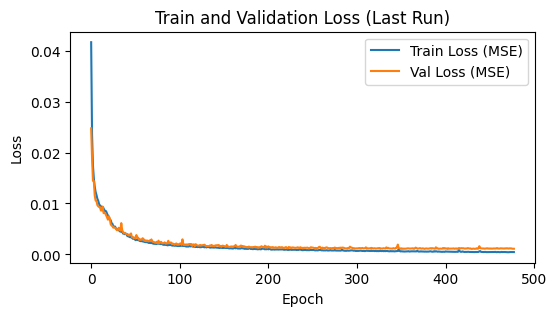

In [4]:
# Draw the Loss curve of the last fold
plt.figure(figsize=(6,3))
plt.plot(last_train_losses, label='Train Loss (MSE)')
plt.plot(last_val_losses, label='Val Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss (Last Run)')
plt.legend()


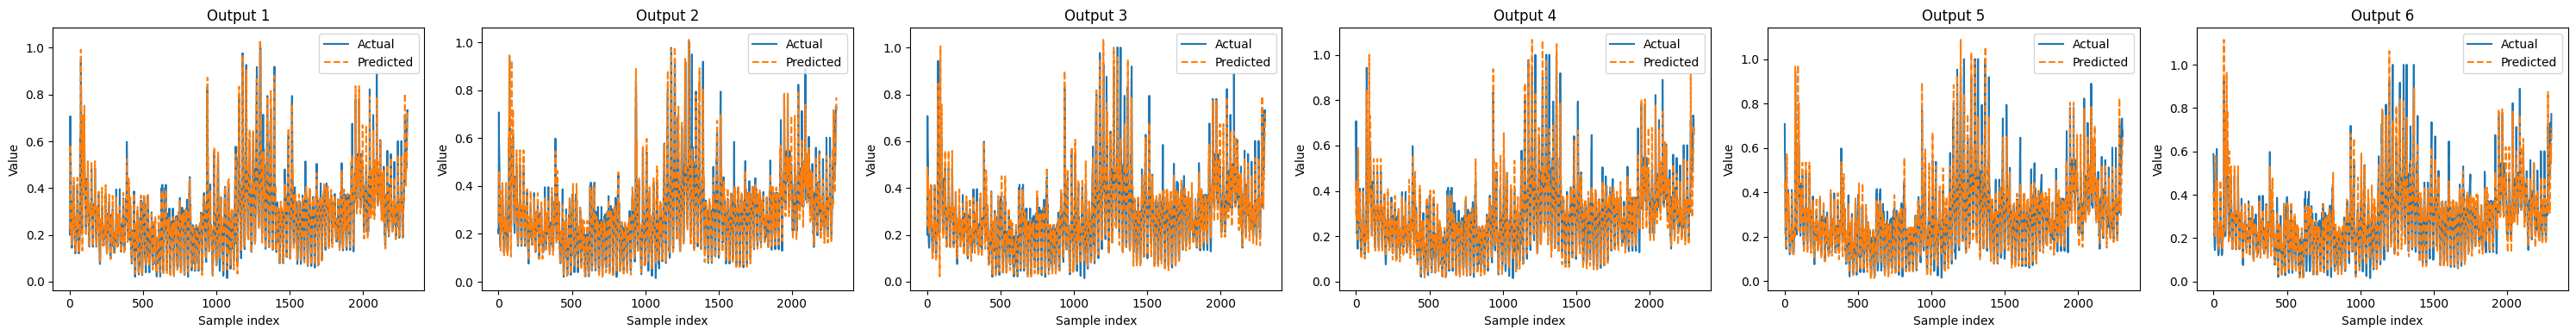

In [5]:
# Plot predictions vs actuals
plt.figure(figsize=(5 * output_dim, 4))
for i in range(output_dim):
    plt.subplot(1, output_dim, i + 1)
    plt.plot(last_y_true[:, i], label='Actual')
    plt.plot(last_y_pred[:, i], label='Predicted', linestyle='--')
    plt.title(f'Output {i+1}')
    plt.xlabel('Sample index')
    plt.ylabel('Value')
    plt.legend()
plt.tight_layout()
plt.show()

